# Fully Bayesian GPs - Sampling Hyperparameters with NUTS

In this notebook, we'll demonstrate how to integrate GPyTorch and NUTS to sample GP hyperparameters and perform GP inference in a fully Bayesian way.

The high level overview of sampling in GPyTorch is as follows:

1. Define your model as normal, extending ExactGP and defining a forward method.
2. For each parameter your model defines, you'll need to register a GPyTorch prior with that parameter, or some function of the parameter. If you use something other than a default closure (e.g., by specifying a parameter or transformed parameter name), you'll need to also specify a setting_closure: see the docs for `gpytorch.Module.register_prior`.
3. Define a pyro model that has a sample site for each GP parameter. For your convenience, we define a `pyro_sample_from_prior` method on `gpytorch.Module` that returns a copy of the module where each parameter has been replaced by the result of a `pyro.sample` call.
4. Run NUTS (or HMC etc) on the pyro model you just defined to generate samples. Note this can take quite a while or no time at all depending on the priors you've defined.
5. Load the samples in to the model, converting the model from a simple GP to a batch GP (see our example notebook on simple batch GPs), where each GP in the batch corresponds to a different hyperparameter sample.
6. Pass test data through the batch GP to get predictions for each hyperparameter sample.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os

import gpytorch
from gpytorch.priors import UniformPrior
import matplotlib.pyplot as plt
import pyro
from pyro.infer.mcmc import NUTS, MCMC
import torch

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)

In [3]:
# Training data is 4 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 4)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

In [4]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## Running Sampling

The next cell is the first piece of code that differs substantially from other work flows. In it, we create the model and likelihood as normal, and then register priors to each of the parameters of the model. Note that we directly can register priors to transformed parameters (e.g., "lengthscale") rather than raw ones (e.g., "raw_lengthscale"). This is useful, **however** you'll need to specify a prior whose support is fully contained in the domain of the parameter. For example, a lengthscale prior must have support only over the positive reals or a subset thereof.

In [5]:
num_samples = 2 if smoke_test else 100
warmup_steps = 2 if smoke_test else 100

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

model.mean_module.register_prior("mean_prior", UniformPrior(-1, 1), "constant")
model.covar_module.base_kernel.register_prior("lengthscale_prior", UniformPrior(0.01, 0.5), "lengthscale")
model.covar_module.register_prior("outputscale_prior", UniformPrior(1, 2), "outputscale")
likelihood.register_prior("noise_prior", UniformPrior(0.01, 0.5), "noise")

def pyro_model(x, y):
    with gpytorch.settings.fast_computations(False, False, False):
        sampled_model = model.pyro_sample_from_prior()
        output = sampled_model.likelihood(sampled_model(x))
        pyro.sample("obs", output, obs=y)
    return y

nuts_kernel = NUTS(pyro_model)
mcmc_run = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps, disable_progbar=smoke_test)
mcmc_run.run(train_x, train_y)

Sample: 100%|██████████| 200/200 [00:12, 15.85it/s, step size=3.88e-01, acc. prob=0.971]


## Loading Samples

In the next cell, we load the samples generated by NUTS in to the model. This converts `model` from a single GP to a batch of `num_samples` GPs, in this case 100.

In [6]:
model.pyro_load_from_samples(mcmc_run.get_samples())

In [7]:
model.eval()
test_x = torch.linspace(0, 1, 101).unsqueeze(-1)
test_y = torch.sin(test_x * (2 * math.pi))
expanded_test_x = test_x.unsqueeze(0).repeat(num_samples, 1, 1)
output = model(expanded_test_x)

## Plot Mean Functions

In the next cell, we plot the first 25 mean functions on the same plot. This particular example has a fairly large amount of data for only 1 dimension, so the hyperparameter posterior is quite tight and there is relatively little variance.

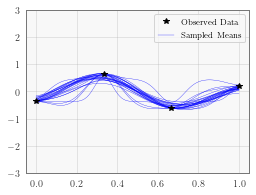

In [8]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*', zorder=10)

    for i in range(min(num_samples, 25)):
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), output.mean[i].detach().numpy(), 'b', linewidth=0.3)

    # Shade between the lower and upper confidence bounds
    # ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Sampled Means'])

## Simulate Loading Model from Disk

Loading a fully Bayesian model from disk is slightly different from loading a standard model because the process of sampling changes the shapes of the model's parameters. To account for this, you'll need to call `load_strict_shapes(False)` on the model before loading the state dict. In the cell below, we demonstrate this by recreating the model and loading from the state dict.

Note that without the `load_strict_shapes` call, this would fail.

In [9]:
state_dict = model.state_dict()
model = ExactGPModel(train_x, train_y, likelihood)

# Load parameters without standard shape checking.
model.load_strict_shapes(False)

model.load_state_dict(state_dict)

<All keys matched successfully>